In [113]:
#Layout for the microplane calcs whith according to MS1 and Bazzant plasticity framework 
# to do
#pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
################################################################
#DOMAIN GEN and loading parameters 
#################################################################
split=True
n_dim = 2 #number of dims in domain
n_mp = 360 #number of microplanes in interpolation 
n_step = 1000 #solver steps
zita=np.zeros(n_step) #fatigue par
fzita=np.ones_like(zita)
tagdisp= 0.01
#ratio=step of defining actual domain
delta = np.identity(n_dim) #Kronecker δij
epsilon_11=np.linspace(0,tagdisp,n_step)#define evenly the lin space from 0 to 0.01 with n_steps is the n in  nijk
#0.01 optional or otherwise raises DeprecationWarning when num cannot be safely interpreted as an integer
epsilon_ij=np.zeros((len(epsilon_11,),n_dim,n_dim))#creation of the finite 2d space
s_ij=np.zeros((n_dim,n_dim))
sm=np.zeros((n_mp,n_dim,n_dim))
mplane=np.linspace(0,n_mp,1)
#s_ij[:,0,0]=mplane
sigma_ij=np.zeros_like(epsilon_ij)
sm[:,0,0]=mplane
sm[0,:,:]=s_ij
epsilon_ij[:,0,0]=epsilon_11 #reshape,arrange,apprehend 
de_ij= ((epsilon_ij[1:] - epsilon_ij[:-1]))
################################################################
#INTEGSCHEMES
################################################################
class IntegScheme():
    alpha_list = np.linspace(0,2*np.pi,n_mp)#polar angle dom
    a_length=alpha_list.size 
    MPN = np.array([[np.cos(alpha),np.sin(alpha)] for alpha in alpha_list ])
    #weights of each microplane
    if n_dim==2:
        MPW = np.ones(n_mp) / n_mp * 2 
    elif n_dim==3:
        MPW = np.ones(n_mp) / n_mp * 6
    MPM = np.zeros_like(MPN)
    delta= np.identity(n_dim) 
    MPNN_nij = np.einsum('ni,nj -> nij', MPN,MPN)
    MPTT_nijr = 0.5*(np.einsum('ni,jr -> nijr',MPN,delta)
                  +np.einsum('nj,ir ->njir',MPN,delta)
                  -2*np.einsum('ni,nj,nr ->nijr',MPN,MPN,MPN))
    NPM=np.zeros_like(MPN)
#################################################################
#DISPS AND INCEMENTS
#################################################################
#strain vector for each microplane
if split==True :
    e_N = np.einsum('nij,...ij->...n',IntegScheme.MPNN_nij,epsilon_ij)
    de_n= np.einsum('...nij,...ij->...n',IntegScheme.MPNN_nij,de_ij)
    MPTT_ijr =  IntegScheme.MPTT_nijr
    e_V_norm = np.einsum('...ij,...ij->...',delta, epsilon_ij)/3
    de_v_norm = np.einsum('...ij,...ij->...',delta, de_ij)/3
    e_V = np.einsum('ij,i->ij', np.ones_like(e_N), e_V_norm)
    de_v = np.einsum('ij,i->ij', np.ones_like(de_n), de_v_norm)
    e_D = e_N - e_V
    de_d=de_n-de_v
    MPN = IntegScheme.MPN
    e_T_r=np.linalg.norm(np.einsum('nija,...ij->...na',MPTT_ijr,epsilon_ij), axis =-1)
    # e_T_r = epsilon_ij - np.einsum('...nij,...ij->...n',e_N,IntegScheme.MPN)
    de_tr=np.linalg.norm(np.einsum('...nija,...ij->...na',MPTT_ijr,de_ij), axis =-1)
    MPTT_ijrax=np.linalg.norm(MPTT_ijr,axis=-1)
    # de_tr=de_ij-np.einsum('...nij,...ij->...n',de_n,IntegScheme.MPN)
else:
    e_N = np.einsum('nij,...ij->...n',IntegScheme.MPNN_nij,epsilon_ij)
    MPTT_ijr =  IntegScheme.MPTT_nijr 
    e_T_r=np.einsum('nija,...ij->...na',MPTT_ijr,epsilon_ij)
################################################################
#ELASTICITY CALCS
################################################################
E_modulus =44800
n_poisson = 0.18
#issuewith if does not exit properly
if n_poisson >=-1 and n_poisson<0.25 : 
    K=E_modulus/(2*(1+n_poisson))
    G=E_modulus/(3*(1-2*n_poisson))
else:
    K=E_modulus/(2*(1+n_poisson))
    G=E_modulus/(3*(1-2*n_poisson))
    K_1=K
    K=E_modulus/(2*(1+n_poisson))
    G_1=0
    K_11 =K+K_1
    G_11 =G+G_1
    n_pseudopoisson=(3*K*(1+G/G_1)-2*G)/(6*K_1*(1+G/G_1)+2*G)
    n_poisson=n_pseudopoisson
E_N=np.ones((len(epsilon_11),n_mp))*E_modulus/(1-2*n_poisson)
E_T=np.ones_like(e_N)*E_modulus/(1-2*n_poisson)*((1-4*n_poisson)/(1+n_poisson)) #initialazation of Elasticity modulus 
E_mod=np.ones_like(E_N)*E_modulus
################################################################
#PARAMETERS AND INITIALASATION
################################################################
k_1=150*10**-6
k_2=110000
k_3=30
k_4=100
k_5=10**-4
f_c0dot=20  #MPa
f_cdot=20   #Mpa 
fc0= 15.08         #MPa Reference compressive strength
zita=np.zeros(n_mp) #faligue par
if fc0>=55:
    r_of_zita=1600  
    q_of_zita=2   
else:
    r_of_zita=750
    q_of_zita=2.5   
c_1= 8.9*10**-2    # Controls the uniaxial tensile strength
c_2= 17.6*10**-2   # Controls the roundness of the peak in uniaxial tension
c_3= 4             # Controls the slope of the postpeak in uniaxial tension
c_4= 50            # Controls the slope of the postpeak tail in uniaxial compression
c_5= 3500          # Controls the volumetric expansion under compression
c_6= 20            # Controls the roundness of the peak in volumetric expansion under compression
c_7= 1             # Controls the slope of the initial postpeak in uniaxial compression
c_8= 8             # Controls the peak strength in uniaxial compression
c_9= 1.2*10**-2    # Controls the peak roundness in uniaxial compression
c_10= 0.33         # Controls the effective friction coefficient
c_11= 0.5          # Initial cohesion in frictional response
c_12= 2.36         # Controls the change of cohesion with tensile volumetric strains
c_13= 4500         # Controls the unloading slope in tension
c_14= 300          # Controls the unloading slope at low hydrostatic compression
c_15= 4000         # Controls the transition from unloading slope at high confinement to that at low confinement
c_16= 60           # Controls the unloading slope at high hydrostatic compression
c_17= 1.4          # Controls the tensile strength
c_18= 1.6*10**-3   # Controls the tensile cracking under compression
c_19= 1000         # Controls the tensile softening rate induced by compression
c_20= 1.8          # Controls the volumetric-deviatoric coupling at high pressures
c_21=250
nomva=1e-20
e_0Nplus=np.zeros(n_mp)
e_0Nminus=np.zeros(n_mp)
s_T_elastic=np.ones((n_step,n_mp))*nomva
s_D_bound=np.ones((n_step,n_mp))*nomva
s_N_bound=np.ones((n_step,n_mp))*nomva
s_V_bound=np.ones((n_step,n_mp))*nomva
s_T_bound=np.ones((n_step,n_mp))*nomva
zita=np.zeros_like(E_N)
fzita=np.zeros_like(E_N)
dzita=np.zeros_like(E_N)
de_vel=np.zeros_like((n_step,n_mp))
s_N=np.ones_like(E_N)*nomva
s_Ndot=np.ones_like(E_N)*nomva
s_V=np.ones_like(E_N)*nomva
s_D=np.ones_like(E_N)*nomva
s_T=np.ones_like(E_N)*nomva
e_elastic=np.zeros_like(E_N)
K_b=np.ones(len(epsilon_11))*E_modulus
#loop over each time step
for j in range(1,n_step):
    #loop over each microplane
    for i in range(n_mp):
        zita[j][i]=zita[j-1][i]+dzita[j][i]
        epsI = np.max(np.linalg.eig(epsilon_ij[j])[0])
        epsII = np.min(np.linalg.eig(epsilon_ij[j])[0])
        if j>0:
            e_elastic[j][i] = np.max([-s_V[j-1][i]/E_N[j-1][i], 0])
        else:
            e_elastic[j][i] = np.max([-s_V[j][i]/E_N[j][i], 0])
        #NOTE: this is not correct! Just by simply printing the value of epsI you should realize that it is not the first eigenvalue since you get a multidimensional array
        # Eingenvalue is a scalar, so it should be a float number. I have just checked the documentation of linalg.eig and corrected the implementation
        #//==>   epsII = np.min(np.linalg.eig(epsilon_ij[i])[0])
        ##########################################################
        #volumentric boundary Eq. 12 - 14
        ##########################################################
        de_v[j-1][i] = e_V[j][i] - e_V[j-1][i] # delta volumetric strain
        if s_V[j-1][i] == 0.0:
            a = k_5 * ((epsI - epsII) / k_1) ** (c_20) + k_4
        else:
            a = (k_5 / (1 + np.min([-s_V[j - 1][i], c_21]) / E_N[j - 1][i])) * ((epsI - epsII) / k_1) ** (c_20) + k_4

        s_V_bound[j][i]=-E_mod[j][i]*k_1*k_3*np.exp(-e_V[j][i]/(k_1*a))
        s_V[j][i] = s_V[j-1][i] + E_mod[j][i]* de_v[j-1][i]
        if s_V[j][i] > s_V_bound[j][i]:
            s_V[j][i] = s_V_bound[j][i]  
        ##########################################################
        #compressive deviatoric boundary Eq. 15 - 18
        ##########################################################
        # predictor for compressive deviatoric stress
        s_D[j][i] = E_mod[j][i] * e_D[j][i]
        # obtaining deviatoric compressive strain boundary (threshold)
        if E_mod[j-1][i]==0:
            gama_0=f_cdot/E_mod[j][i]
        else :
            gama_0=f_c0dot/E_mod[j-1][i]+f_cdot/E_mod[j][i]
        if e_V[j-1][i] == 0.0:
            gama_1=0
        else:
            gama_1=np.exp(gama_0)*(np.tanh(c_9*(-e_V[j][i])/k_1))
        bita_2=c_5*gama_1+c_7
        bita_3=c_6*gama_1+c_8
        s_D_bound[j][i]=E_mod[j][i]*k_1*bita_3/(1+6*((-e_D[j][i])/k_1*bita_2)**2)
        # checking if we are crossing the boundary for time step j and microplane i
        if e_N[j][i] < 0:
            # if we cross boundary, correct microplane i stress
            if s_D[j][i] < s_D_bound[j][i]:
                # corrector deviatoric stress
                s_D[j][i] = s_D_bound[j][i]
        ##########################################################
        #Normal boundary Eq. 19 - 24
        ##########################################################
        de_n[j-1][i]= e_N[j][i] - e_N[j-1][i]
        if s_N[j-1][i]>=0:      #Compression
            if de_n[j-1][i] > 0:
                fzita[j][i]=1+r_of_zita*zita[j][i]**q_of_zita+(r_of_zita**2)*(zita[j][i]**(2*q_of_zita))
                E_N[j][i]=E_N[j-1][i]*np.exp(-c_13*e_0Nplus[i])*(fzita[j][i])**-1
            elif s_N[j-1][i]>E_N[j-1][i] and s_N[j-1][i]*de_n[j-1][i]<0:
                E_N [j][i]= E_N[j-1][i]
        else:
            E_N[j][i]=E_N[j-1][i]*(np.exp(-c_14*np.abs(e_0Nminus[i])/(1+c_15*e_elastic[j][i]))+c_16*e_elastic[j][i])    
        s_N[j][i] = s_N[j-1][i] + E_N [j][i]* de_n[j-1][i]
        E_mod[j][i]=(1-2*n_poisson)*E_N[j][i]
        if s_N[j][i] > 0 :
            if s_V[j-1][i]==0:
                bita_1=-c_1+c_17*np.exp(-c_19*(-c_18)/E_N[j][i])
            else :
                bita_1=-c_1+c_17*np.exp(-c_19*(-s_V[j-1][i]-c_18)/E_N[j-1][i])
            s_N_bound[j][i]=E_mod[j][i]*k_1*bita_1*np.exp(-(e_N[j][i]-bita_1*c_2*k_1)/(-c_4*e_elastic[j][i]+k_1*c_3))
            if s_N[j][i] > s_N_bound[j][i]: 
                s_N[j][i]=np.max([np.min([s_N[j][i],s_N_bound[j][i]]),s_V_bound[j][i]+s_D_bound[j][i]])
                e_0Nminus[i]=np.amin(e_N[j][i])
                e_0Nplus[i]=np.amax(e_N[j][i])
        ##########################################################
        #Shear boundary Eq.  24-32
        ##########################################################
        E_T[j][i]= E_N[j][i]*((1-4*n_poisson)/(1+n_poisson))         
        s_Ndot[j][i]=E_T[j][i]*k_1*c_11-c_12*e_V[j][i]#shouldnt it be inside the microplane loop 
        if s_N[j][i]<=0:
            s_T_bound[j][i]=(c_10*(s_Ndot[j][i]-s_N[j][i])**(-1)+(E_T[j][i]*k_1-k_2)**(-1))**(-1)
        else:
            s_T_bound[j][i]=(c_10*s_Ndot[j][i]**(-1)+(E_T[j][i]*k_1-k_2)**(-1))**(-1)
        s_T_elastic[j][i]=s_T[j-1][i] +E_T[j][i]*de_tr[j-1][i]
        if s_T_elastic[j][i]==0:
            s_T_elastic[j][i]=nomva
        s_T[j][i]=np.minimum(s_T_bound[j][i],np.abs(s_T_elastic[j][i]))
        s_T[j][i]=(s_T[j-1][i]+E_T[j][i]*de_tr[j-1][i])*s_T[j][i]/s_T_elastic[j][i]

        if (s_V[j][i]-s_V[j][i]) > 1e-20:
             de_vel[j-1][i]=(s_V[j][i]-s_V[j][i])*(K_b[j]**-1)
             dzita[j][i]=np.abs(de_v[j-1][i]-de_vel[j-1][i])
        else :
            dzita[j][i]=0
           # s_ij[i] =np.einsum('...n,...nij->ij',s_N[j][i],IntegScheme.MPNN_nij)+np.einsum('...n,...nij->ij',s_T[j][i],MPTT_ijrax)
    s_V[j,:]=np.einsum('...i,i',s_V[j],IntegScheme.MPW)
   #s_N[j,:]=np.einsum('...i,i',s_N[j],IntegScheme.MPW)
    #s_T[j,:]=np.einsum('...i,i',s_T[j],IntegScheme.MPW)
    #s_D[j,:]=np.einsum('...i,i',s_D[j],IntegScheme.MPW)
    K_b[j]=(2/3)*np.einsum('...n,...n->...',IntegScheme.MPW,E_N[j])
    s_ij =np.einsum('...n,...nij->ij',s_N[j],IntegScheme.MPNN_nij)+np.einsum('...n,...nij->ij',s_T[j],MPTT_ijrax)
    sm[0,:,:]=s_ij
    sigma_ij[j]=np.einsum('...n,...nij->ij',IntegScheme.MPW,sm)




C:\Users\Rob\AppData\Local\Temp\ipykernel_4480\3726361522.py:241: RuntimeWarning: overflow encountered in double_scalars
  s_T[j][i]=(s_T[j-1][i]+E_T[j][i]*de_tr[j-1][i])*s_T[j][i]/s_T_elastic[j][i]
C:\Users\Rob\AppData\Local\Temp\ipykernel_4480\3726361522.py:241: RuntimeWarning: invalid value encountered in double_scalars
  s_T[j][i]=(s_T[j-1][i]+E_T[j][i]*de_tr[j-1][i])*s_T[j][i]/s_T_elastic[j][i]


In [116]:
microplane = 60 #46°
cm = 1 / 2.54  # centimeters in inches%matplotlib widget
fontlabel=20
labl=5
legend_entries= []

from ipywidgets import interactive
def Polarplot_2D(VAL,Stepin,title):
        rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
        plt.plot(rads, VAL[Stepin-1][:], 'k')
        #plt.ylim(1.3*tagdisp)
        #plt.ylim(-1.5 * np.max(np.abs(VAL)),
        #        1.5 * np.max(np.abs(VAL)))
        #plt.set_rmax(1.3*np.abs(np.max(VAL),np.min(VAL)))
        plt.title(title, fontsize=fontlabel)
        plt.tick_params(axis='both', which='major', labelsize=labl)
        legend_entries.append('step'+str(Stepin))



def Control_Plane(n_step):
        plt.figure(figsize=(20*cm, 20*cm))
        plt.subplot(2,3,1, projection='polar')
        Polarplot_2D(e_V,n_step,'e_V')
        plt.subplot(2,3,2,projection='polar')
        Polarplot_2D(e_D,n_step,'e_D')
        plt.subplot(2,3,3,projection='polar')
        Polarplot_2D(e_T_r,n_step,'e_T_r')
        plt.subplot(2,3,4,projection='polar')
        Polarplot_2D(s_V,n_step,'s_V')
        plt.subplot(2,3,5,projection='polar')
        Polarplot_2D(s_D,n_step,'s_D')
        plt.subplot(2,3,6,projection='polar')
        Polarplot_2D(s_T,n_step,'s_T')
        plt.tight_layout()
        plt.show()
#iplot=interactive(Control_Plane,
#                  n_step=(1,len(epsilon_11)))
#iplot

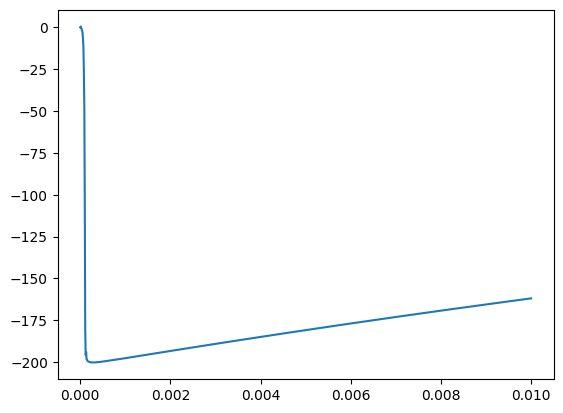

In [108]:
X=epsilon_ij[:,0,0]
Y=sigma_ij[:,0,0]
plt.plot(X,Y)

plt.show()

In [106]:
X.shape

(1000,)

interactive(children=(IntSlider(value=500, description='n_step', max=1000, min=1), Output()), _dom_classes=('w…

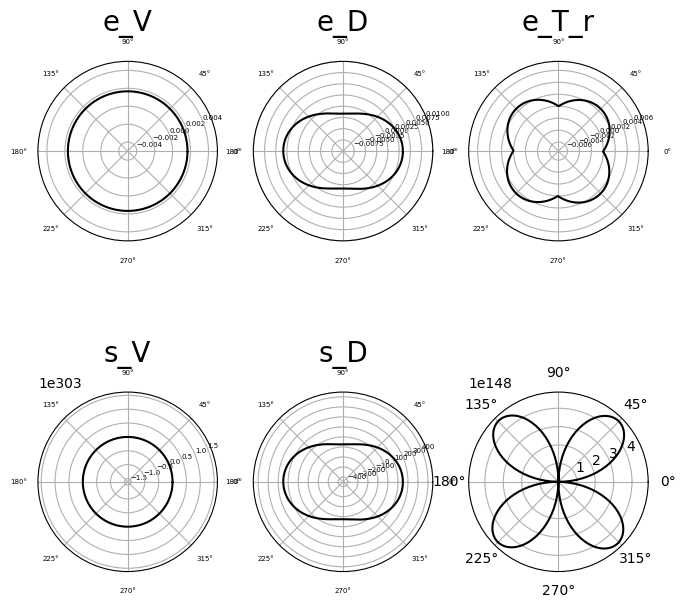

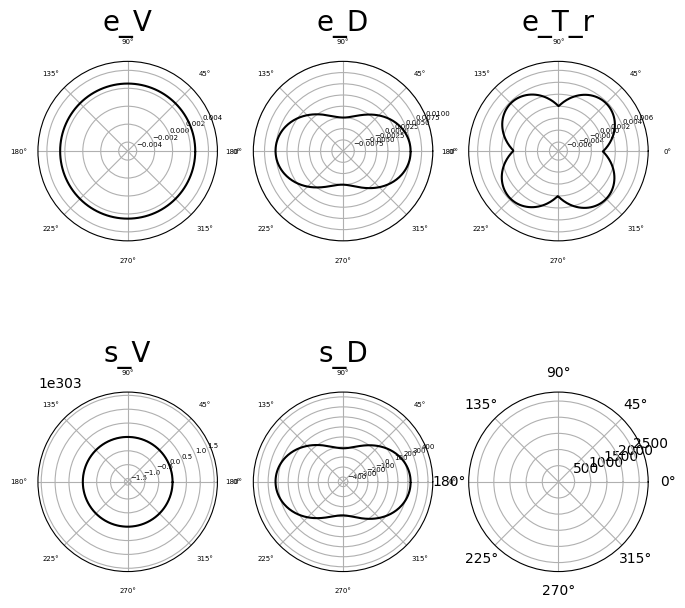

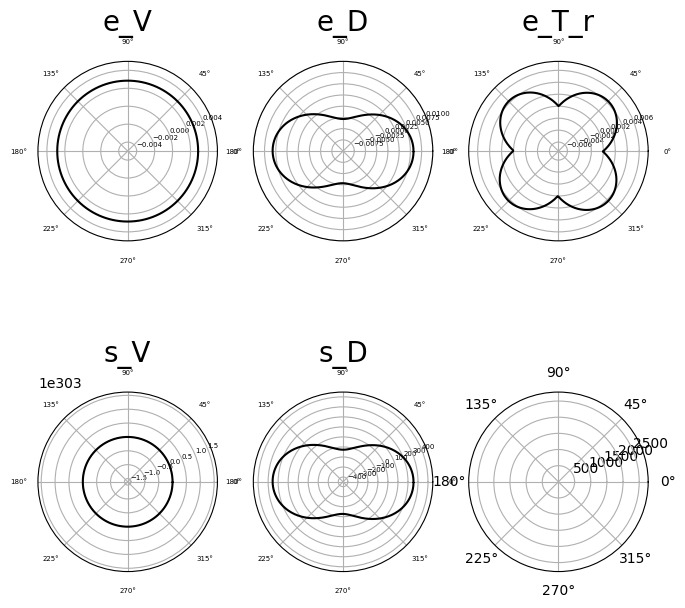

In [117]:
iplot=interactive(Control_Plane,
                  n_step=(1,len(epsilon_11)))
iplot